<a href="https://colab.research.google.com/github/cadenzonnefeld/NaturalDisasterTweetClassification/blob/main/DisasterTweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Natural Language Processign with Disaster Tweets Kaggle Competition**

The goal of this challenge is to use tweets provided that offer text describing weather events that may lead to disaster. Twitter offers nearly instantaneous updates from many in the general public and there is potential for valuable information to be gleaned from how users describe the weather phenomena they are encountering.

\\
In this notebook, we will create a NLP solution that processes the sentiment and content of several thousand tweets. The aim of the NLP is to identify classify if the text of a tweet is referring to real weather disaster. Once we have arrived at a satisfactory solution, we will score the test data and submit the holdout predictions to the Kaggle competition to evaluate the quality of our predictions.

\\
The evaluation metric for the quality of predictions is F1 Score which is defined as:

$F_{1} = 2*\frac{precision * recall}{precision + recall}$

Where $precision = \frac{TP}{TP + FP}$ and $recall = \frac{TP}{TP+FN}$

F1 Score is a popular metric for binary classification since it calculates class-wise performance instead of overall performance which is captured by a measure like accuracy. The F1 Score combines precision and recall which allows for evaluation of a model's predictive capacity regardless of class baance.

\\
The primary technique we will use to tackle this classification problem is a Recurrent Neural Network (RNN). RNNs have the benefit of maintaining information over time which proves useful for sequential problems.

### Package Import

In [1]:
import os
import tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive, files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Loading and Exploration

The train data consists of 7,613 tweets that have the following features: ID, keyword, loctation, text (main body of tweet), and target. Few of the tweets have a keyword or location. There are 61 tweets with a missing keyword and 2533 (about 1/3) with a missing location.

---



In [3]:
train = pd.read_csv('drive/MyDrive/Colab Notebooks/DisasterTweets/train.csv')
print("Train Data Shape:", train.shape)
print("Train Data Example:")
train.head()

Train Data Shape: (7613, 5)
Train Data Example:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print('Null Values by Feature')
train.isnull().sum()

Null Values by Feature


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

The test data consists of 3263 tweets that have the following features: ID, keyword, loctation, text (main body of tweet), and target. Few of the tweets have a keyword or location. There are 26 tweets with a missing keyword and 1105 (about 1/3) with a missing location.

In [5]:
test = pd.read_csv('drive/MyDrive/Colab Notebooks/DisasterTweets/test.csv')
print("Test Data Shape:", test.shape)
print("Test Data Example:")
test.head()

Test Data Shape: (3263, 4)
Test Data Example:


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
print('Null Values by Feature')
test.isnull().sum()

Null Values by Feature


id             0
keyword       26
location    1105
text           0
dtype: int64

We empirically observe the train test split to be 70% train to 30% test. Note above we can see that they split on ID as the IDs begin at 0 and alternate between train and test.

In [7]:
print("Train Proportion:", np.round(train.shape[0]/(test.shape[0]+train.shape[0]), 4))
print("Test Proportion:", np.round(test.shape[0]/(test.shape[0]+train.shape[0]), 4))

Train Proportion: 0.7
Test Proportion: 0.3


Example of a sample submisson. The goal of the project will be to create an NLP solution and assign predictions about whether or not a tweet signals a real disaster. These predictions will be made on the tweets in the test dataset and be submitted in a format that looks like the following with IDs and their associated classifications.

In [8]:
sample_submission = pd.read_csv('drive/MyDrive/Colab Notebooks/DisasterTweets/sample_submission.csv')
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


### Exploratory Data Analysis (EDA)

Examining the data types of the features in train

In [9]:
train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

The class balance of the target (0:No Disaster 1:Disaster)

Not quite balanced but pretty solid balance nonetheless.

In [10]:
train.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

Replacing any occurence of the float 'NAN' in the dataset with the string 'None' to unify data types in the keyword and location columns. Allows us to look at the unique keywords in the next cell.

In [11]:
train = train.replace(np.nan, 'None')

In [12]:
print("Unique Keywords in Train:", len(np.unique(train.keyword)))
np.unique(train.keyword)

Unique Keywords in Train: 222


array(['None', 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', '

Frequency of keywords in the train dataset. Fairly balanced distribution with no non-null keyword having less than 9 or more than 45.

In [13]:
train.keyword.value_counts()

None                     61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

Text(0, 0.5, 'Frequency')

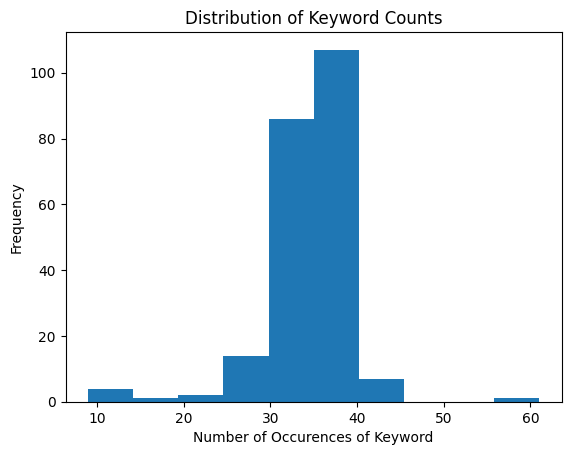

In [14]:
plt.hist(train.keyword.value_counts())
plt.title('Distribution of Keyword Counts')
plt.xlabel('Number of Occurences of Keyword')
plt.ylabel('Frequency')

While the keywords in the tweets were fairly balanced the locations vary greatly. There are 3342 unique locations, which, if you exlude the 'None's leaves an average of about 2 tweets per unique location.

In [15]:
print("Unique Locations in Train:", len(np.unique(train.location)))
np.unique(train.location)

Unique Locations in Train: 3342


array(['  ', '  Glasgow ', '  Melbourne, Australia', ...,
       'å¡å¡Midwest \x89Û¢\x89Û¢', 'åÊ(?\x89Û¢`?\x89Û¢å«)??',
       'åø\\_(?)_/åø'], dtype=object)

In [16]:
train.location.value_counts()

None                            2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: location, Length: 3342, dtype: int64

Calculating the average number of characters in each tweet text body.

In [17]:
text_characters = [len(text) for text in train.text]
print("Average Tweet Length:", np.round(np.mean(text_characters),1), "characters")

Average Tweet Length: 101.0 characters


Examing test data types and replacing the float "NAN" with the string "None" for consistency in the keyword and location attribute data types.

In [18]:
test.dtypes

id           int64
keyword     object
location    object
text        object
dtype: object

In [19]:
test = test.replace(np.nan, 'None')

Test data has the same keywords as the train dataset. Likewise, the frequency of keywords inhabits a relatively narrow range of 1-25ish.

In [20]:
test.keyword.value_counts()

None             26
deluged          23
demolished       22
rubble           22
snowstorm        21
                 ..
threat            5
fatalities        5
forest%20fire     5
inundation        4
epicentre         1
Name: keyword, Length: 222, dtype: int64

Text(0, 0.5, 'Frequency')

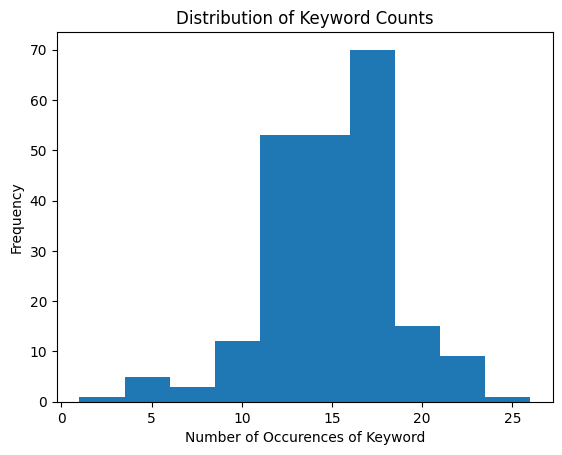

In [21]:
plt.hist(test.keyword.value_counts())
plt.title('Distribution of Keyword Counts')
plt.xlabel('Number of Occurences of Keyword')
plt.ylabel('Frequency')

In [22]:
test.location.value_counts()

None                      1105
New York                    38
USA                         37
Worldwide                   16
United States               15
                          ... 
Quezon City                  1
LanÌ¼s                       1
USA,Washington,Seattle       1
Roanoke, VA                  1
Brussels, Belgium            1
Name: location, Length: 1603, dtype: int64

Calculating the average number of characters in each tweet text body.

In [23]:
text_characters = [len(text) for text in test.text]
print("Average Tweet Length:", np.round(np.mean(text_characters),1), "characters")

Average Tweet Length: 102.1 characters


Recall that the average tweet length in the training set was 101 characters; thus we can conclude that the tweets are of similar lengths on average.

Splitting the training data into train and validation portions to allow us to effectively validate the model that we will fit on the data.

In [24]:
train_X, val_X, train_y, val_y = train_test_split(train['text'], train['target'], test_size=0.3, random_state=1)

In [25]:
print("Train X Shape:",train_X.shape)
print("Train y Shape:",train_y.shape)
print("Validation X Shape:",val_X.shape)
print("Validation y Shape:",val_y.shape)

Train X Shape: (5329,)
Train y Shape: (5329,)
Validation X Shape: (2284,)
Validation y Shape: (2284,)


### Processing Tweet Text into Matrix Form

We will be utilizing Term Frequency - Inverse Document Frequency (TF-IDF) to translate the text of the tweets into word embeddings.

Instantiating a TF-IDF Vectorizer, we specify min_df which is the minimum number of documents in which a word must appear in to be considered (i.e. if min_df=5 any words that appear in less than 5 documents will be exlcuded) and max_df which is the max proportion of documents a word can be included in to be considered (i.e. if 'ran' appeared in 99% of documents it would be excluded).

In [26]:
tfidf = TfidfVectorizer(stop_words='english', min_df = 2, max_df = 0.98)

Fit the TF-IDF Vectorizor on the training data and applying it to the validation (and eventually test) data.

In [27]:
train_tfidf = tfidf.fit_transform(train_X)
train_tfidf = np.array(train_tfidf.todense())
print("Shape of embedded training data:", train_tfidf.shape)
print("Example of embedded data:")
pd.DataFrame(train_tfidf).head()

Shape of embedded training data: (5329, 4987)
Example of embedded data:


,0,1,2,3,4,5,6,7,8,9,...,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.287921,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [28]:
val_tfidf = tfidf.transform(val_X)
val_tfidf = np.array(val_tfidf.todense())
print("Shape of embedded validation data:", val_tfidf.shape)

Shape of embedded validation data: (2284, 4987)


Reshaping the X and y data so that it has the proper dimensions to be fed into a Recurrent Neural Network (RNN).

In [29]:
train_matrix = np.reshape(train_tfidf, (train_tfidf.shape[0], 1, train_tfidf.shape[1]))
val_matrix = np.reshape(val_tfidf, (val_tfidf.shape[0], 1, val_tfidf.shape[1]))

In [30]:
train_y = np.array(train_y)
val_y = np.array(val_y)

In [31]:
train_y = train_y.reshape(train_y.shape[0], 1)
val_y = val_y.reshape(val_y.shape[0], 1)

In [32]:
print(train_matrix.shape)
print(val_matrix.shape)
print(train_y.shape)
print(val_y.shape)

(5329, 1, 4987)
(2284, 1, 4987)
(5329, 1)
(2284, 1)


### Model Architecture

The algorithm/model architecture of choice for this project is an RNN. An RNN feeds information from the prior step into the current step and as such has the benefit of preseving all information that it sees over time. There are numerous approaches to RNN's with Long Short Term Memory (LSTM) and Gated Recurrent Unit (GRU) being popular implementations.

#### Stacked LSTM
Implementing a simple RNN with two Long Short Term Memory layers with 32 an 4 units repsectively. Likewise, they include dropout and recurrent dropout rates of 50%. The output from LSTM is mapped to a dense layer with a sigmoid activation to give the classification of the model.

In [229]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, input_shape=(train_matrix.shape[1], train_matrix.shape[2])))
stacked_lstm.add(LSTM(4, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
stacked_lstm.add(Dense(1, activation = 'sigmoid'))

In [230]:
stacked_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])
stacked_lstm_history = stacked_lstm.fit(train_matrix, train_y, epochs = 10, batch_size=1, validation_data=(val_matrix, val_y))

Epoch 1/10
5329/5329 [==============================] - 60s 10ms/step - loss: 0.6089 - accuracy: 0.6695 - auc: 0.7216 - val_loss: 0.4876 - val_accuracy: 0.7785 - val_auc: 0.8406
Epoch 2/10
5329/5329 [==============================] - 57s 11ms/step - loss: 0.4703 - accuracy: 0.7861 - auc: 0.8499 - val_loss: 0.4570 - val_accuracy: 0.7929 - val_auc: 0.8512
Epoch 3/10
5329/5329 [==============================] - 53s 10ms/step - loss: 0.4307 - accuracy: 0.8086 - auc: 0.8757 - val_loss: 0.4519 - val_accuracy: 0.7977 - val_auc: 0.8525
Epoch 4/10
5329/5329 [==============================] - 58s 11ms/step - loss: 0.4080 - accuracy: 0.8197 - auc: 0.8886 - val_loss: 0.4535 - val_accuracy: 0.7929 - val_auc: 0.8487
Epoch 5/10
5329/5329 [==============================] - 52s 10ms/step - loss: 0.3917 - accuracy: 0.8259 - auc: 0.8985 - val_loss: 0.4587 - val_accuracy: 0.7951 - val_auc: 0.8491
Epoch 6/10
5329/5329 [==============================] - 52s 10ms/step - loss: 0.3770 - accuracy: 0.8322 - auc:

Trying out a single layer LSTM with 32 nodes and the same dropout strategy as the prior model.

In [242]:
single_lstm = Sequential()
single_lstm.add(LSTM(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, input_shape=(train_matrix.shape[1], train_matrix.shape[2])))
single_lstm.add(Dense(1, activation = 'sigmoid'))

In [243]:
single_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])
single_lstm_history = single_lstm.fit(train_matrix, train_y, epochs = 10, batch_size=1, validation_data=(val_matrix, val_y))

Epoch 1/10
5329/5329 [==============================] - 45s 8ms/step - loss: 0.5847 - accuracy: 0.6994 - auc: 0.7504 - val_loss: 0.4762 - val_accuracy: 0.7890 - val_auc: 0.8462
Epoch 2/10
5329/5329 [==============================] - 41s 8ms/step - loss: 0.4587 - accuracy: 0.7940 - auc: 0.8574 - val_loss: 0.4586 - val_accuracy: 0.7951 - val_auc: 0.8511
Epoch 3/10
5329/5329 [==============================] - 40s 7ms/step - loss: 0.4176 - accuracy: 0.8137 - auc: 0.8830 - val_loss: 0.4663 - val_accuracy: 0.7912 - val_auc: 0.8460
Epoch 4/10
5329/5329 [==============================] - 37s 7ms/step - loss: 0.4003 - accuracy: 0.8199 - auc: 0.8929 - val_loss: 0.4712 - val_accuracy: 0.8034 - val_auc: 0.8470
Epoch 5/10
5329/5329 [==============================] - 41s 8ms/step - loss: 0.3873 - accuracy: 0.8257 - auc: 0.8992 - val_loss: 0.4682 - val_accuracy: 0.7912 - val_auc: 0.8480
Epoch 6/10
5329/5329 [==============================] - 47s 9ms/step - loss: 0.3725 - accuracy: 0.8337 - auc: 0.908

#### Stacked GRU
Implementing a simple RNN with two Gated Recurrent Unit layers with 32 an 4 units repsectively. Likewise, they include dropout and recurrent dropout rates of 50%. The output from GRU

```
# This is formatted as code
```

 is mapped to a dense layer with a sigmoid activation to give the classification of the model.

In [237]:
stacked_gru = Sequential()
stacked_gru.add(GRU(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.5, input_shape=(train_matrix.shape[1], train_matrix.shape[2])))
stacked_gru.add(GRU(4, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
stacked_gru.add(Dense(1, activation = 'sigmoid'))

In [238]:
stacked_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])
stacked_gru_history = stacked_gru.fit(train_matrix, train_y, epochs = 10, batch_size=1, validation_data=(val_matrix, val_y))

Epoch 1/10
5329/5329 [==============================] - 59s 10ms/step - loss: 0.5928 - accuracy: 0.6814 - auc: 0.7321 - val_loss: 0.4772 - val_accuracy: 0.7890 - val_auc: 0.8453
Epoch 2/10
5329/5329 [==============================] - 67s 13ms/step - loss: 0.4664 - accuracy: 0.7878 - auc: 0.8492 - val_loss: 0.4564 - val_accuracy: 0.7920 - val_auc: 0.8487
Epoch 3/10
5329/5329 [==============================] - 65s 12ms/step - loss: 0.4157 - accuracy: 0.8193 - auc: 0.8839 - val_loss: 0.4610 - val_accuracy: 0.7894 - val_auc: 0.8480
Epoch 4/10
5329/5329 [==============================] - 56s 10ms/step - loss: 0.4013 - accuracy: 0.8229 - auc: 0.8906 - val_loss: 0.4548 - val_accuracy: 0.7920 - val_auc: 0.8525
Epoch 5/10
5329/5329 [==============================] - 53s 10ms/step - loss: 0.3878 - accuracy: 0.8298 - auc: 0.8986 - val_loss: 0.4564 - val_accuracy: 0.7973 - val_auc: 0.8533
Epoch 6/10
5329/5329 [==============================] - 57s 11ms/step - loss: 0.3747 - accuracy: 0.8388 - auc:

#### Gridsearch GRU
Implementing a simple RNN with a Gated Recurrent Unit and gridsearching through a handful of the adjustable hyperparameters. Restricted the search space to dropout rate, batch size, and number of units in the GRU layer due to memory and time constraints.

Would have been interested in adding more hyperparameters and levels if better equipment access were available. The grid includes levels of 35%, 50%, and 65% for dropout rate, batch sizes of 1, 32, and 128, and GRU layer nodes of 4, 16, and 64.

In [244]:
for dropout in [0.35, 0.5, 0.65]:
  for batch_size in [1, 32, 128]:
    for nodes in [4, 16, 64]:
      print("\nRNN with dropout rate:", dropout, "batch_size:", batch_size,"nodes:", nodes)
      model = Sequential()
      model.add(GRU(nodes, return_sequences=True, dropout=dropout, recurrent_dropout=dropout, input_shape=(train_matrix.shape[1], train_matrix.shape[2])))
      model.add(Dense(1, activation = 'sigmoid'))

      model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])
      model.fit(train_matrix, train_y, epochs = 5, batch_size=batch_size, validation_data=(val_matrix, val_y))


RNN with dropout rate: 0.35 batch_size: 1 nodes: 4
Epoch 1/5
5329/5329 [==============================] - 43s 8ms/step - loss: 0.5880 - accuracy: 0.6936 - auc: 0.7638 - val_loss: 0.4773 - val_accuracy: 0.7903 - val_auc: 0.8503
Epoch 2/5
5329/5329 [==============================] - 51s 10ms/step - loss: 0.4289 - accuracy: 0.8127 - auc: 0.8760 - val_loss: 0.4519 - val_accuracy: 0.7920 - val_auc: 0.8552
Epoch 3/5
5329/5329 [==============================] - 44s 8ms/step - loss: 0.3747 - accuracy: 0.8416 - auc: 0.9064 - val_loss: 0.4648 - val_accuracy: 0.7982 - val_auc: 0.8551
Epoch 4/5
5329/5329 [==============================] - 46s 9ms/step - loss: 0.3526 - accuracy: 0.8474 - auc: 0.9176 - val_loss: 0.4705 - val_accuracy: 0.7938 - val_auc: 0.8543
Epoch 5/5
5329/5329 [==============================] - 50s 9ms/step - loss: 0.3282 - accuracy: 0.8589 - auc: 0.9302 - val_loss: 0.4846 - val_accuracy: 0.7916 - val_auc: 0.8507



RNN with dropout rate: 0.35 batch_size: 1 nodes: 16
Epoch 1/5
5329/5329 [==============================] - 47s 8ms/step - loss: 0.5645 - accuracy: 0.7174 - auc: 0.7713 - val_loss: 0.4644 - val_accuracy: 0.7868 - val_auc: 0.8477
Epoch 2/5
5329/5329 [==============================] - 45s 8ms/step - loss: 0.4135 - accuracy: 0.8217 - auc: 0.8843 - val_loss: 0.4596 - val_accuracy: 0.7881 - val_auc: 0.8554
Epoch 3/5
5329/5329 [==============================] - 45s 8ms/step - loss: 0.3668 - accuracy: 0.8442 - auc: 0.9115 - val_loss: 0.4598 - val_accuracy: 0.7960 - val_auc: 0.8555
Epoch 4/5
5329/5329 [==============================] - 41s 8ms/step - loss: 0.3397 - accuracy: 0.8503 - auc: 0.9251 - val_loss: 0.4754 - val_accuracy: 0.7863 - val_auc: 0.8485
Epoch 5/5
5329/5329 [==============================] - 39s 7ms/step - loss: 0.3174 - accuracy: 0.8645 - auc: 0.9341 - val_loss: 0.4806 - val_accuracy: 0.7877 - val_auc: 0.8474



RNN with dropout rate: 0.35 batch_size: 1 nodes: 64
Epoch 1/5
5329/5329 [==============================] - 38s 7ms/step - loss: 0.5506 - accuracy: 0.7264 - auc: 0.7824 - val_loss: 0.4623 - val_accuracy: 0.7960 - val_auc: 0.8504
Epoch 2/5
5329/5329 [==============================] - 34s 6ms/step - loss: 0.4154 - accuracy: 0.8155 - auc: 0.8858 - val_loss: 0.4605 - val_accuracy: 0.7955 - val_auc: 0.8502
Epoch 3/5
5329/5329 [==============================] - 40s 8ms/step - loss: 0.3723 - accuracy: 0.8399 - auc: 0.9077 - val_loss: 0.4611 - val_accuracy: 0.7964 - val_auc: 0.8494
Epoch 4/5
5329/5329 [==============================] - 34s 6ms/step - loss: 0.3373 - accuracy: 0.8534 - auc: 0.9254 - val_loss: 0.4662 - val_accuracy: 0.7885 - val_auc: 0.8473
Epoch 5/5
5329/5329 [==============================] - 35s 7ms/step - loss: 0.3096 - accuracy: 0.8656 - auc: 0.9371 - val_loss: 0.4782 - val_accuracy: 0.7837 - val_auc: 0.8477



RNN with dropout rate: 0.35 batch_size: 32 nodes: 4
Epoch 1/5
167/167 [==============================] - 5s 15ms/step - loss: 0.6733 - accuracy: 0.5830 - auc: 0.6470 - val_loss: 0.6478 - val_accuracy: 0.6265 - val_auc: 0.8345
Epoch 2/5
167/167 [==============================] - 2s 12ms/step - loss: 0.6148 - accuracy: 0.6847 - auc: 0.8596 - val_loss: 0.5895 - val_accuracy: 0.7364 - val_auc: 0.8484
Epoch 3/5
167/167 [==============================] - 3s 18ms/step - loss: 0.5391 - accuracy: 0.7851 - auc: 0.8846 - val_loss: 0.5308 - val_accuracy: 0.7855 - val_auc: 0.8535
Epoch 4/5
167/167 [==============================] - 3s 15ms/step - loss: 0.4729 - accuracy: 0.8148 - auc: 0.8984 - val_loss: 0.4919 - val_accuracy: 0.7982 - val_auc: 0.8560
Epoch 5/5
167/167 [==============================] - 2s 11ms/step - loss: 0.4225 - accuracy: 0.8347 - auc: 0.9108 - val_loss: 0.4687 - val_accuracy: 0.7995 - val_auc: 0.8567



RNN with dropout rate: 0.35 batch_size: 32 nodes: 16
Epoch 1/5
167/167 [==============================] - 6s 14ms/step - loss: 0.6671 - accuracy: 0.5898 - auc: 0.6743 - val_loss: 0.6287 - val_accuracy: 0.6716 - val_auc: 0.8421
Epoch 2/5
167/167 [==============================] - 2s 12ms/step - loss: 0.5706 - accuracy: 0.7463 - auc: 0.8635 - val_loss: 0.5307 - val_accuracy: 0.7855 - val_auc: 0.8509
Epoch 3/5
167/167 [==============================] - 2s 11ms/step - loss: 0.4592 - accuracy: 0.8185 - auc: 0.8897 - val_loss: 0.4731 - val_accuracy: 0.7977 - val_auc: 0.8533
Epoch 4/5
167/167 [==============================] - 2s 12ms/step - loss: 0.3887 - accuracy: 0.8414 - auc: 0.9137 - val_loss: 0.4549 - val_accuracy: 0.7890 - val_auc: 0.8539
Epoch 5/5
167/167 [==============================] - 3s 21ms/step - loss: 0.3570 - accuracy: 0.8503 - auc: 0.9222 - val_loss: 0.4560 - val_accuracy: 0.7894 - val_auc: 0.8525



RNN with dropout rate: 0.35 batch_size: 32 nodes: 64
Epoch 1/5
167/167 [==============================] - 5s 14ms/step - loss: 0.6421 - accuracy: 0.6386 - auc: 0.7447 - val_loss: 0.5627 - val_accuracy: 0.7588 - val_auc: 0.8497
Epoch 2/5
167/167 [==============================] - 2s 12ms/step - loss: 0.4780 - accuracy: 0.8002 - auc: 0.8717 - val_loss: 0.4629 - val_accuracy: 0.7907 - val_auc: 0.8529
Epoch 3/5
167/167 [==============================] - 2s 11ms/step - loss: 0.3863 - accuracy: 0.8347 - auc: 0.9048 - val_loss: 0.4555 - val_accuracy: 0.7912 - val_auc: 0.8537
Epoch 4/5
167/167 [==============================] - 3s 16ms/step - loss: 0.3432 - accuracy: 0.8503 - auc: 0.9243 - val_loss: 0.4687 - val_accuracy: 0.7881 - val_auc: 0.8489
Epoch 5/5
167/167 [==============================] - 3s 17ms/step - loss: 0.3173 - accuracy: 0.8626 - auc: 0.9350 - val_loss: 0.4933 - val_accuracy: 0.7868 - val_auc: 0.8430



RNN with dropout rate: 0.35 batch_size: 128 nodes: 4
Epoch 1/5
42/42 [==============================] - 4s 27ms/step - loss: 0.6861 - accuracy: 0.5761 - auc: 0.6020 - val_loss: 0.6767 - val_accuracy: 0.5845 - val_auc: 0.7871
Epoch 2/5
42/42 [==============================] - 1s 15ms/step - loss: 0.6683 - accuracy: 0.5761 - auc: 0.8090 - val_loss: 0.6604 - val_accuracy: 0.5933 - val_auc: 0.8332
Epoch 3/5
42/42 [==============================] - 1s 15ms/step - loss: 0.6482 - accuracy: 0.6057 - auc: 0.8795 - val_loss: 0.6435 - val_accuracy: 0.6305 - val_auc: 0.8435
Epoch 4/5
42/42 [==============================] - 1s 13ms/step - loss: 0.6261 - accuracy: 0.6553 - auc: 0.8964 - val_loss: 0.6242 - val_accuracy: 0.6747 - val_auc: 0.8474
Epoch 5/5
42/42 [==============================] - 1s 13ms/step - loss: 0.5999 - accuracy: 0.7153 - auc: 0.9017 - val_loss: 0.6031 - val_accuracy: 0.7158 - val_auc: 0.8502

RNN with dropout rate: 0.35 batch_size: 128 nodes: 16


Epoch 1/5
42/42 [==============================] - 6s 42ms/step - loss: 0.6845 - accuracy: 0.5703 - auc: 0.6132 - val_loss: 0.6716 - val_accuracy: 0.5889 - val_auc: 0.8212
Epoch 2/5
42/42 [==============================] - 1s 15ms/step - loss: 0.6584 - accuracy: 0.5999 - auc: 0.8386 - val_loss: 0.6458 - val_accuracy: 0.6283 - val_auc: 0.8444
Epoch 3/5
42/42 [==============================] - 1s 14ms/step - loss: 0.6251 - accuracy: 0.6562 - auc: 0.8813 - val_loss: 0.6141 - val_accuracy: 0.6926 - val_auc: 0.8501
Epoch 4/5
42/42 [==============================] - 1s 15ms/step - loss: 0.5810 - accuracy: 0.7439 - auc: 0.8935 - val_loss: 0.5771 - val_accuracy: 0.7557 - val_auc: 0.8537
Epoch 5/5
42/42 [==============================] - 1s 13ms/step - loss: 0.5322 - accuracy: 0.7992 - auc: 0.9043 - val_loss: 0.5408 - val_accuracy: 0.7846 - val_auc: 0.8538



RNN with dropout rate: 0.35 batch_size: 128 nodes: 64
Epoch 1/5
42/42 [==============================] - 4s 29ms/step - loss: 0.6722 - accuracy: 0.5845 - auc: 0.6636 - val_loss: 0.6444 - val_accuracy: 0.6353 - val_auc: 0.8420
Epoch 2/5
42/42 [==============================] - 1s 15ms/step - loss: 0.6097 - accuracy: 0.6921 - auc: 0.8790 - val_loss: 0.5864 - val_accuracy: 0.7417 - val_auc: 0.8511
Epoch 3/5
42/42 [==============================] - 1s 13ms/step - loss: 0.5343 - accuracy: 0.7958 - auc: 0.8905 - val_loss: 0.5260 - val_accuracy: 0.7929 - val_auc: 0.8545
Epoch 4/5
42/42 [==============================] - 1s 14ms/step - loss: 0.4591 - accuracy: 0.8260 - auc: 0.9052 - val_loss: 0.4842 - val_accuracy: 0.8004 - val_auc: 0.8559
Epoch 5/5
42/42 [==============================] - 1s 13ms/step - loss: 0.4049 - accuracy: 0.8469 - auc: 0.9170 - val_loss: 0.4619 - val_accuracy: 0.7999 - val_auc: 0.8558



RNN with dropout rate: 0.5 batch_size: 1 nodes: 4
Epoch 1/5
5329/5329 [==============================] - 41s 7ms/step - loss: 0.6150 - accuracy: 0.6596 - auc: 0.7342 - val_loss: 0.5015 - val_accuracy: 0.7815 - val_auc: 0.8424
Epoch 2/5
5329/5329 [==============================] - 38s 7ms/step - loss: 0.4766 - accuracy: 0.7831 - auc: 0.8458 - val_loss: 0.4599 - val_accuracy: 0.7877 - val_auc: 0.8522
Epoch 3/5
5329/5329 [==============================] - 40s 7ms/step - loss: 0.4192 - accuracy: 0.8118 - auc: 0.8820 - val_loss: 0.4552 - val_accuracy: 0.7955 - val_auc: 0.8518
Epoch 4/5
5329/5329 [==============================] - 40s 8ms/step - loss: 0.4015 - accuracy: 0.8257 - auc: 0.8928 - val_loss: 0.4610 - val_accuracy: 0.7907 - val_auc: 0.8495
Epoch 5/5
5329/5329 [==============================] - 40s 8ms/step - loss: 0.3734 - accuracy: 0.8394 - auc: 0.9075 - val_loss: 0.4658 - val_accuracy: 0.7920 - val_auc: 0.8505



RNN with dropout rate: 0.5 batch_size: 1 nodes: 16
Epoch 1/5
5329/5329 [==============================] - 43s 8ms/step - loss: 0.5812 - accuracy: 0.6964 - auc: 0.7547 - val_loss: 0.4781 - val_accuracy: 0.7828 - val_auc: 0.8445
Epoch 2/5
5329/5329 [==============================] - 40s 7ms/step - loss: 0.4580 - accuracy: 0.7911 - auc: 0.8581 - val_loss: 0.4606 - val_accuracy: 0.7933 - val_auc: 0.8499
Epoch 3/5
5329/5329 [==============================] - 35s 7ms/step - loss: 0.4132 - accuracy: 0.8150 - auc: 0.8859 - val_loss: 0.4603 - val_accuracy: 0.7912 - val_auc: 0.8500
Epoch 4/5
5329/5329 [==============================] - 36s 7ms/step - loss: 0.3817 - accuracy: 0.8296 - auc: 0.9026 - val_loss: 0.4581 - val_accuracy: 0.7885 - val_auc: 0.8515
Epoch 5/5
5329/5329 [==============================] - 40s 7ms/step - loss: 0.3680 - accuracy: 0.8409 - auc: 0.9106 - val_loss: 0.4677 - val_accuracy: 0.7877 - val_auc: 0.8504



RNN with dropout rate: 0.5 batch_size: 1 nodes: 64
Epoch 1/5
5329/5329 [==============================] - 38s 7ms/step - loss: 0.5693 - accuracy: 0.7074 - auc: 0.7612 - val_loss: 0.4799 - val_accuracy: 0.7868 - val_auc: 0.8373
Epoch 2/5
5329/5329 [==============================] - 34s 6ms/step - loss: 0.4605 - accuracy: 0.7964 - auc: 0.8533 - val_loss: 0.4635 - val_accuracy: 0.7916 - val_auc: 0.8476
Epoch 3/5
5329/5329 [==============================] - 39s 7ms/step - loss: 0.4122 - accuracy: 0.8176 - auc: 0.8861 - val_loss: 0.4612 - val_accuracy: 0.7951 - val_auc: 0.8470
Epoch 4/5
5329/5329 [==============================] - 36s 7ms/step - loss: 0.3847 - accuracy: 0.8289 - auc: 0.9009 - val_loss: 0.4649 - val_accuracy: 0.7877 - val_auc: 0.8451
Epoch 5/5
5329/5329 [==============================] - 34s 6ms/step - loss: 0.3715 - accuracy: 0.8382 - auc: 0.9079 - val_loss: 0.4632 - val_accuracy: 0.7890 - val_auc: 0.8478



RNN with dropout rate: 0.5 batch_size: 32 nodes: 4
Epoch 1/5
167/167 [==============================] - 5s 15ms/step - loss: 0.6773 - accuracy: 0.5727 - auc: 0.6253 - val_loss: 0.6578 - val_accuracy: 0.5985 - val_auc: 0.8278
Epoch 2/5
167/167 [==============================] - 2s 12ms/step - loss: 0.6355 - accuracy: 0.6350 - auc: 0.8344 - val_loss: 0.6133 - val_accuracy: 0.6970 - val_auc: 0.8416
Epoch 3/5
167/167 [==============================] - 4s 22ms/step - loss: 0.5740 - accuracy: 0.7467 - auc: 0.8627 - val_loss: 0.5582 - val_accuracy: 0.7653 - val_auc: 0.8473
Epoch 4/5
167/167 [==============================] - 2s 11ms/step - loss: 0.5111 - accuracy: 0.7908 - auc: 0.8782 - val_loss: 0.5139 - val_accuracy: 0.7907 - val_auc: 0.8509
Epoch 5/5
167/167 [==============================] - 2s 11ms/step - loss: 0.4711 - accuracy: 0.8039 - auc: 0.8815 - val_loss: 0.4874 - val_accuracy: 0.7920 - val_auc: 0.8522



RNN with dropout rate: 0.5 batch_size: 32 nodes: 16
Epoch 1/5
167/167 [==============================] - 5s 15ms/step - loss: 0.6672 - accuracy: 0.5907 - auc: 0.6744 - val_loss: 0.6310 - val_accuracy: 0.6708 - val_auc: 0.8390
Epoch 2/5
167/167 [==============================] - 2s 12ms/step - loss: 0.5836 - accuracy: 0.7335 - auc: 0.8394 - val_loss: 0.5406 - val_accuracy: 0.7837 - val_auc: 0.8511
Epoch 3/5
167/167 [==============================] - 2s 12ms/step - loss: 0.4903 - accuracy: 0.7951 - auc: 0.8691 - val_loss: 0.4874 - val_accuracy: 0.7912 - val_auc: 0.8527
Epoch 4/5
167/167 [==============================] - 3s 18ms/step - loss: 0.4327 - accuracy: 0.8155 - auc: 0.8874 - val_loss: 0.4623 - val_accuracy: 0.7938 - val_auc: 0.8518
Epoch 5/5
167/167 [==============================] - 3s 16ms/step - loss: 0.3942 - accuracy: 0.8302 - auc: 0.9037 - val_loss: 0.4546 - val_accuracy: 0.7894 - val_auc: 0.8535



RNN with dropout rate: 0.5 batch_size: 32 nodes: 64
Epoch 1/5
167/167 [==============================] - 7s 15ms/step - loss: 0.6494 - accuracy: 0.6243 - auc: 0.7133 - val_loss: 0.5781 - val_accuracy: 0.7417 - val_auc: 0.8443
Epoch 2/5
167/167 [==============================] - 2s 12ms/step - loss: 0.5109 - accuracy: 0.7784 - auc: 0.8466 - val_loss: 0.4781 - val_accuracy: 0.7859 - val_auc: 0.8519
Epoch 3/5
167/167 [==============================] - 2s 11ms/step - loss: 0.4333 - accuracy: 0.8077 - auc: 0.8768 - val_loss: 0.4570 - val_accuracy: 0.7912 - val_auc: 0.8505
Epoch 4/5
167/167 [==============================] - 2s 11ms/step - loss: 0.4007 - accuracy: 0.8185 - auc: 0.8938 - val_loss: 0.4599 - val_accuracy: 0.7903 - val_auc: 0.8479
Epoch 5/5
167/167 [==============================] - 2s 12ms/step - loss: 0.3662 - accuracy: 0.8369 - auc: 0.9119 - val_loss: 0.4666 - val_accuracy: 0.7877 - val_auc: 0.8466



RNN with dropout rate: 0.5 batch_size: 128 nodes: 4
Epoch 1/5
42/42 [==============================] - 5s 44ms/step - loss: 0.6880 - accuracy: 0.5673 - auc: 0.5733 - val_loss: 0.6800 - val_accuracy: 0.5806 - val_auc: 0.7765
Epoch 2/5
42/42 [==============================] - 1s 25ms/step - loss: 0.6741 - accuracy: 0.5737 - auc: 0.7671 - val_loss: 0.6667 - val_accuracy: 0.5832 - val_auc: 0.8318
Epoch 3/5
42/42 [==============================] - 1s 13ms/step - loss: 0.6586 - accuracy: 0.5830 - auc: 0.8456 - val_loss: 0.6523 - val_accuracy: 0.5994 - val_auc: 0.8436
Epoch 4/5
42/42 [==============================] - 1s 16ms/step - loss: 0.6402 - accuracy: 0.6185 - auc: 0.8754 - val_loss: 0.6363 - val_accuracy: 0.6379 - val_auc: 0.8482
Epoch 5/5
42/42 [==============================] - 1s 14ms/step - loss: 0.6204 - accuracy: 0.6615 - auc: 0.8802 - val_loss: 0.6182 - val_accuracy: 0.6830 - val_auc: 0.8488



RNN with dropout rate: 0.5 batch_size: 128 nodes: 16
Epoch 1/5
42/42 [==============================] - 5s 43ms/step - loss: 0.6823 - accuracy: 0.5813 - auc: 0.6204 - val_loss: 0.6682 - val_accuracy: 0.5841 - val_auc: 0.8075
Epoch 2/5
42/42 [==============================] - 1s 25ms/step - loss: 0.6560 - accuracy: 0.5945 - auc: 0.8246 - val_loss: 0.6431 - val_accuracy: 0.6283 - val_auc: 0.8378
Epoch 3/5
42/42 [==============================] - 1s 23ms/step - loss: 0.6233 - accuracy: 0.6585 - auc: 0.8603 - val_loss: 0.6129 - val_accuracy: 0.6988 - val_auc: 0.8455
Epoch 4/5
42/42 [==============================] - 1s 16ms/step - loss: 0.5825 - accuracy: 0.7414 - auc: 0.8730 - val_loss: 0.5796 - val_accuracy: 0.7566 - val_auc: 0.8492
Epoch 5/5
42/42 [==============================] - 1s 15ms/step - loss: 0.5417 - accuracy: 0.7844 - auc: 0.8825 - val_loss: 0.5463 - val_accuracy: 0.7732 - val_auc: 0.8516



RNN with dropout rate: 0.5 batch_size: 128 nodes: 64
Epoch 1/5
42/42 [==============================] - 4s 32ms/step - loss: 0.6739 - accuracy: 0.5836 - auc: 0.6490 - val_loss: 0.6494 - val_accuracy: 0.6173 - val_auc: 0.8315
Epoch 2/5
42/42 [==============================] - 1s 22ms/step - loss: 0.6220 - accuracy: 0.6645 - auc: 0.8472 - val_loss: 0.5993 - val_accuracy: 0.7320 - val_auc: 0.8437
Epoch 3/5
42/42 [==============================] - 1s 23ms/step - loss: 0.5556 - accuracy: 0.7651 - auc: 0.8639 - val_loss: 0.5432 - val_accuracy: 0.7894 - val_auc: 0.8499
Epoch 4/5
42/42 [==============================] - 1s 24ms/step - loss: 0.4911 - accuracy: 0.8030 - auc: 0.8819 - val_loss: 0.4984 - val_accuracy: 0.7986 - val_auc: 0.8528
Epoch 5/5
42/42 [==============================] - 1s 22ms/step - loss: 0.4413 - accuracy: 0.8193 - auc: 0.8927 - val_loss: 0.4736 - val_accuracy: 0.8012 - val_auc: 0.8534



RNN with dropout rate: 0.65 batch_size: 1 nodes: 4
Epoch 1/5
5329/5329 [==============================] - 42s 7ms/step - loss: 0.6433 - accuracy: 0.6299 - auc: 0.6842 - val_loss: 0.5465 - val_accuracy: 0.7771 - val_auc: 0.8352
Epoch 2/5
5329/5329 [==============================] - 39s 7ms/step - loss: 0.5259 - accuracy: 0.7527 - auc: 0.8099 - val_loss: 0.4748 - val_accuracy: 0.7990 - val_auc: 0.8452
Epoch 3/5
5329/5329 [==============================] - 34s 6ms/step - loss: 0.4731 - accuracy: 0.7825 - auc: 0.8493 - val_loss: 0.4560 - val_accuracy: 0.8012 - val_auc: 0.8529
Epoch 4/5
5329/5329 [==============================] - 40s 7ms/step - loss: 0.4601 - accuracy: 0.7985 - auc: 0.8580 - val_loss: 0.4559 - val_accuracy: 0.8004 - val_auc: 0.8517
Epoch 5/5
5329/5329 [==============================] - 39s 7ms/step - loss: 0.4380 - accuracy: 0.8024 - auc: 0.8710 - val_loss: 0.4546 - val_accuracy: 0.7990 - val_auc: 0.8513



RNN with dropout rate: 0.65 batch_size: 1 nodes: 16
Epoch 1/5
5329/5329 [==============================] - 42s 8ms/step - loss: 0.6131 - accuracy: 0.6727 - auc: 0.7175 - val_loss: 0.5003 - val_accuracy: 0.7806 - val_auc: 0.8376
Epoch 2/5
5329/5329 [==============================] - 40s 7ms/step - loss: 0.5034 - accuracy: 0.7632 - auc: 0.8217 - val_loss: 0.4671 - val_accuracy: 0.7890 - val_auc: 0.8443
Epoch 3/5
5329/5329 [==============================] - 36s 7ms/step - loss: 0.4703 - accuracy: 0.7836 - auc: 0.8513 - val_loss: 0.4610 - val_accuracy: 0.7925 - val_auc: 0.8482
Epoch 4/5
5329/5329 [==============================] - 39s 7ms/step - loss: 0.4489 - accuracy: 0.8026 - auc: 0.8668 - val_loss: 0.4630 - val_accuracy: 0.7938 - val_auc: 0.8490
Epoch 5/5
5329/5329 [==============================] - 39s 7ms/step - loss: 0.4262 - accuracy: 0.8159 - auc: 0.8800 - val_loss: 0.4588 - val_accuracy: 0.7855 - val_auc: 0.8502



RNN with dropout rate: 0.65 batch_size: 1 nodes: 64
Epoch 1/5
5329/5329 [==============================] - 37s 6ms/step - loss: 0.6034 - accuracy: 0.6772 - auc: 0.7194 - val_loss: 0.4957 - val_accuracy: 0.7960 - val_auc: 0.8442
Epoch 2/5
5329/5329 [==============================] - 35s 7ms/step - loss: 0.5053 - accuracy: 0.7639 - auc: 0.8239 - val_loss: 0.4736 - val_accuracy: 0.7968 - val_auc: 0.8482
Epoch 3/5
5329/5329 [==============================] - 39s 7ms/step - loss: 0.4683 - accuracy: 0.7861 - auc: 0.8513 - val_loss: 0.4622 - val_accuracy: 0.7973 - val_auc: 0.8486
Epoch 4/5
5329/5329 [==============================] - 34s 6ms/step - loss: 0.4588 - accuracy: 0.7904 - auc: 0.8592 - val_loss: 0.4598 - val_accuracy: 0.7973 - val_auc: 0.8492
Epoch 5/5
5329/5329 [==============================] - 35s 7ms/step - loss: 0.4157 - accuracy: 0.8161 - auc: 0.8845 - val_loss: 0.4613 - val_accuracy: 0.7938 - val_auc: 0.8478



RNN with dropout rate: 0.65 batch_size: 32 nodes: 4
Epoch 1/5
167/167 [==============================] - 5s 15ms/step - loss: 0.6833 - accuracy: 0.5643 - auc: 0.5719 - val_loss: 0.6684 - val_accuracy: 0.5806 - val_auc: 0.8157
Epoch 2/5
167/167 [==============================] - 2s 11ms/step - loss: 0.6545 - accuracy: 0.5995 - auc: 0.7792 - val_loss: 0.6355 - val_accuracy: 0.6265 - val_auc: 0.8411
Epoch 3/5
167/167 [==============================] - 2s 12ms/step - loss: 0.6137 - accuracy: 0.6795 - auc: 0.8152 - val_loss: 0.5905 - val_accuracy: 0.7356 - val_auc: 0.8485
Epoch 4/5
167/167 [==============================] - 4s 21ms/step - loss: 0.5591 - accuracy: 0.7476 - auc: 0.8422 - val_loss: 0.5449 - val_accuracy: 0.7846 - val_auc: 0.8532
Epoch 5/5
167/167 [==============================] - 2s 12ms/step - loss: 0.5180 - accuracy: 0.7741 - auc: 0.8484 - val_loss: 0.5115 - val_accuracy: 0.7933 - val_auc: 0.8544



RNN with dropout rate: 0.65 batch_size: 32 nodes: 16
Epoch 1/5
167/167 [==============================] - 6s 15ms/step - loss: 0.6772 - accuracy: 0.5703 - auc: 0.6005 - val_loss: 0.6539 - val_accuracy: 0.5950 - val_auc: 0.8280
Epoch 2/5
167/167 [==============================] - 2s 12ms/step - loss: 0.6201 - accuracy: 0.6602 - auc: 0.8067 - val_loss: 0.5824 - val_accuracy: 0.7329 - val_auc: 0.8421
Epoch 3/5
167/167 [==============================] - 2s 11ms/step - loss: 0.5406 - accuracy: 0.7530 - auc: 0.8334 - val_loss: 0.5133 - val_accuracy: 0.7833 - val_auc: 0.8484
Epoch 4/5
167/167 [==============================] - 2s 12ms/step - loss: 0.4914 - accuracy: 0.7767 - auc: 0.8479 - val_loss: 0.4776 - val_accuracy: 0.7907 - val_auc: 0.8540
Epoch 5/5
167/167 [==============================] - 3s 18ms/step - loss: 0.4561 - accuracy: 0.7840 - auc: 0.8643 - val_loss: 0.4609 - val_accuracy: 0.7968 - val_auc: 0.8548



RNN with dropout rate: 0.65 batch_size: 32 nodes: 64
Epoch 1/5
167/167 [==============================] - 7s 20ms/step - loss: 0.6588 - accuracy: 0.6072 - auc: 0.6727 - val_loss: 0.6057 - val_accuracy: 0.6944 - val_auc: 0.8347
Epoch 2/5
167/167 [==============================] - 2s 11ms/step - loss: 0.5511 - accuracy: 0.7409 - auc: 0.8104 - val_loss: 0.5027 - val_accuracy: 0.7890 - val_auc: 0.8445
Epoch 3/5
167/167 [==============================] - 2s 11ms/step - loss: 0.4882 - accuracy: 0.7703 - auc: 0.8396 - val_loss: 0.4757 - val_accuracy: 0.7903 - val_auc: 0.8455
Epoch 4/5
167/167 [==============================] - 2s 11ms/step - loss: 0.4586 - accuracy: 0.7880 - auc: 0.8574 - val_loss: 0.4692 - val_accuracy: 0.7837 - val_auc: 0.8443
Epoch 5/5
167/167 [==============================] - 2s 11ms/step - loss: 0.4390 - accuracy: 0.7970 - auc: 0.8698 - val_loss: 0.4675 - val_accuracy: 0.7820 - val_auc: 0.8437



RNN with dropout rate: 0.65 batch_size: 128 nodes: 4
Epoch 1/5
42/42 [==============================] - 8s 44ms/step - loss: 0.6878 - accuracy: 0.5699 - auc: 0.5715 - val_loss: 0.6807 - val_accuracy: 0.5806 - val_auc: 0.7616
Epoch 2/5
42/42 [==============================] - 1s 13ms/step - loss: 0.6758 - accuracy: 0.5729 - auc: 0.7228 - val_loss: 0.6686 - val_accuracy: 0.5806 - val_auc: 0.8240
Epoch 3/5
42/42 [==============================] - 1s 17ms/step - loss: 0.6624 - accuracy: 0.5834 - auc: 0.8083 - val_loss: 0.6563 - val_accuracy: 0.5898 - val_auc: 0.8400
Epoch 4/5
42/42 [==============================] - 1s 15ms/step - loss: 0.6479 - accuracy: 0.6076 - auc: 0.8312 - val_loss: 0.6427 - val_accuracy: 0.6195 - val_auc: 0.8488
Epoch 5/5
42/42 [==============================] - 1s 15ms/step - loss: 0.6294 - accuracy: 0.6543 - auc: 0.8526 - val_loss: 0.6273 - val_accuracy: 0.6576 - val_auc: 0.8510



RNN with dropout rate: 0.65 batch_size: 128 nodes: 16
Epoch 1/5
42/42 [==============================] - 4s 29ms/step - loss: 0.6858 - accuracy: 0.5637 - auc: 0.5760 - val_loss: 0.6741 - val_accuracy: 0.5806 - val_auc: 0.7995
Epoch 2/5
42/42 [==============================] - 1s 13ms/step - loss: 0.6656 - accuracy: 0.5847 - auc: 0.7625 - val_loss: 0.6542 - val_accuracy: 0.6020 - val_auc: 0.8356
Epoch 3/5
42/42 [==============================] - 1s 15ms/step - loss: 0.6406 - accuracy: 0.6283 - auc: 0.8306 - val_loss: 0.6301 - val_accuracy: 0.6480 - val_auc: 0.8452
Epoch 4/5
42/42 [==============================] - 1s 14ms/step - loss: 0.6095 - accuracy: 0.6840 - auc: 0.8445 - val_loss: 0.6016 - val_accuracy: 0.7229 - val_auc: 0.8501
Epoch 5/5
42/42 [==============================] - 1s 16ms/step - loss: 0.5783 - accuracy: 0.7452 - auc: 0.8425 - val_loss: 0.5711 - val_accuracy: 0.7706 - val_auc: 0.8531



RNN with dropout rate: 0.65 batch_size: 128 nodes: 64
Epoch 1/5
42/42 [==============================] - 5s 29ms/step - loss: 0.6769 - accuracy: 0.5853 - auc: 0.6139 - val_loss: 0.6554 - val_accuracy: 0.6007 - val_auc: 0.8227
Epoch 2/5
42/42 [==============================] - 1s 15ms/step - loss: 0.6339 - accuracy: 0.6446 - auc: 0.8121 - val_loss: 0.6127 - val_accuracy: 0.7032 - val_auc: 0.8413
Epoch 3/5
42/42 [==============================] - 1s 14ms/step - loss: 0.5789 - accuracy: 0.7363 - auc: 0.8355 - val_loss: 0.5603 - val_accuracy: 0.7644 - val_auc: 0.8478
Epoch 4/5
42/42 [==============================] - 1s 15ms/step - loss: 0.5286 - accuracy: 0.7679 - auc: 0.8463 - val_loss: 0.5171 - val_accuracy: 0.7925 - val_auc: 0.8528
Epoch 5/5
42/42 [==============================] - 1s 15ms/step - loss: 0.4901 - accuracy: 0.7855 - auc: 0.8563 - val_loss: 0.4885 - val_accuracy: 0.7990 - val_auc: 0.8545


The grid search reveals several trends about the performance of RNNs as specified. One takeaway is that RNN's take time (more than 5 epochs) to fit will when batch_size>>nodes. Another thing of note is that the higher dropout rates tended to provide better performance due to reducing the problem of overfitting. Lastly, we note that the RNN with a dropout rate of 65%, batch size of 1, and 4 nodes likely yields the best perofrmance as it couples high AUC with multiple epochs that have accuracy over 80%.

In [45]:
best = Sequential()
best.add(GRU(4, return_sequences=True, dropout=0.65, recurrent_dropout=0.65, input_shape=(train_matrix.shape[1], train_matrix.shape[2])))
best.add(Dense(1, activation = 'sigmoid'))

best.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])
best_hist = model.fit(train_matrix, train_y, epochs = 4, batch_size=1, validation_data=(val_matrix, val_y))

Epoch 1/4
5329/5329 [==============================] - 36s 7ms/step - loss: 0.4563 - accuracy: 0.7956 - auc: 0.8598 - val_loss: 0.4567 - val_accuracy: 0.7995 - val_auc: 0.8496
Epoch 2/4
5329/5329 [==============================] - 37s 7ms/step - loss: 0.4466 - accuracy: 0.7975 - auc: 0.8636 - val_loss: 0.4547 - val_accuracy: 0.7947 - val_auc: 0.8499
Epoch 3/4
5329/5329 [==============================] - 41s 8ms/step - loss: 0.4444 - accuracy: 0.7960 - auc: 0.8688 - val_loss: 0.4586 - val_accuracy: 0.7986 - val_auc: 0.8493
Epoch 4/4
5329/5329 [==============================] - 41s 8ms/step - loss: 0.4423 - accuracy: 0.8077 - auc: 0.8660 - val_loss: 0.4549 - val_accuracy: 0.7955 - val_auc: 0.8505


### Scoring on Test Dataset
Vectorizing the test data, scoring the vectorized data, and preparing for kaggle submission.

In [46]:
test_tfidf = tfidf.transform(test.text)
test_tfidf = np.array(test_tfidf.todense())
print("Shape of embedded test data:", test_tfidf.shape)

Shape of embedded test data: (3263, 4987)


In [47]:
test_matrix = np.reshape(test_tfidf, (-1, 1, test_tfidf.shape[1]))
print("Shape of test matrix", test_matrix.shape)

Shape of test matrix (3263, 1, 4987)


In [48]:
test_probabilities = best.predict(test_matrix)

102/102 [==============================] - 1s 3ms/step


In [49]:
test_labels = np.round(test_probabilities).astype(int)

output = pd.DataFrame()
output['id'] = test.id
output['target'] = test_labels.reshape(-1, 1)

In [50]:
output.to_csv('test_labels.csv')
files.download('test_labels.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion
The results of our efforts to create a RNN that classifies tweets according to whether or not they are a weather disaster resulted in a model that yields an F1-Score of ~80% on test set.

\\
In the process we used NLP techniques like TF-IDF and also tried two different types of RNN layers with GRU and LSTM networks built. Once we honed in on GRU, we conducted a gridsearch which identified the best model in that search space. We also observed from the gridsearch that a 4:1 ratio of nodes:batch size seems to be a heuristic for more effective classifiers as opposed to other combinations we processed. The hyperparameters we focused on were batch size, number of nodes in a layer, and dropout rate. Dropout rate in particular was helpful as performance noticeably increased once we included dropouts to protect against over-fitting.

\\
If given more time it would have been intersting to expand the search space for the hyperparameters and consider other model architectures.